Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшие 90 дней.

<br>Цель:
<br>Предсказать вероятность покупки в течение 90 дней

<br>Задачи
<br>- Изучить данные
<br>- Разработать полезные признаки
<br>- Создать модель для классификации пользователей
<br>- Обучить модель и найти метрику roc-auc
<br>- Выполнить тестирование

<br>Данные:
<br>apparel-purchases - история покупок
<br>- client_id - идентификатор пользователя
<br>- quantity - количество товаров в заказе
<br>- price - цена товара
<br>- category_ids - вложенные категории, к которым отнсится товар
<br>- date - дата покупки
<br>- message_id - идентификатор сообщения из рассылки

<br>apparel-messages - история рекламных рассылок
<br>- bulk_campaign_id - идентификатор рекламной кампании
<br>- client_id - идентификатор пользователя
<br>- message_id - идентификатор сообщений
<br>- event - тип события
<br>- channel - канал рассылки
<br>- date - дата рассылки
<br>- created_at - точное время создания сообщения

<br>apparel-target_binary - совершит ли клиент покупку в течение следующих 90 дней
<br>- client_id - идентификатор пользователя
<br>- target - целевой признак

## Шаг 1. Загрузка данных

In [1]:
!pip install -U scikit-learn -q
!pip install shap -q
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
import warnings

import catboost
import lightgbm

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

try:
    from yellowbrick.classifier import ROCAUC
except ImportError:
    !pip install yellowbrick
    from yellowbrick.classifier import ROCAUC


from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier


RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
#функция вывода основной информации о таблице
def information(data):
    print(f'Размер фрейма {data.shape} \n')
    print('Первые пять строк таблицы')
    display(data.head())
    print('\n Основная информация о файле')
    print(data.info())

In [4]:
#Функция визуализации количественных данных
def eda_quantity(data, bins_num):
    quantity_columns = data.select_dtypes(include = ['int64', 'int32', 'int8', 'float64', 'float32']).columns.to_list()
    #num_plots = len(quantity_columns)

    #plt.figure(figsize=(20, 10 * num_plots))
    plt.rcParams ['figure.figsize'] = [15, 8]

    for c in quantity_columns:
        print(f'Статистический анализ столбца: {c}')
        print(data[c].describe().round(2))

        f, (ax_hist, ax_box) = plt.subplots(1, 2)

        sns.histplot(data=data, x=c, bins=bins_num, ax=ax_hist)
        ax_hist.set(xlabel=c, ylabel='Количество', title=f'Гистограмма для {c}')

        sns.boxplot(y=data[c], ax=ax_box)
        ax_box.set(ylabel=c, title=f'Ящик с усами для {c}')

        plt.show();

In [5]:
#Функция визуализации категориальных переменных
def eda_quality(data):
    quality_columns = data.select_dtypes(include = 'object').columns.to_list()
    num_plots = len(quality_columns)
    plt.figure(figsize=(10, 5))

    for c in quality_columns:
        data_temp = data.groupby([c])[c].agg(['count']).sort_values(by='count')
        data_temp['percent'] = data_temp['count'] / data_temp['count'].sum()
        data_temp.columns = {'Количество':'count', 'Доля':'percent'}
        print(f'Значения столбца {c} \n {data_temp} \n')
        print(f'Статистический анализ столбца {c} \n', data_temp.describe())

        sns.barplot(x=data_temp['Количество'].values, y=data_temp.index)
        plt.gca().set(xlabel='количество', ylabel=f'${c}$')
        plt.title(f'{c}')
        plt.show()

In [6]:
#функция визуализации корреляции признаков
def corr_matrix(data):
    interval_cols = data.select_dtypes(include=['number']).columns
    phik_overview = phik_matrix(data, interval_cols=interval_cols)
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1,
        figsize=(10, 8)
    )

In [7]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [8]:
path1 = "C:/Users/User/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv"
path2 = "C:/Users/User/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv"
path3 = "C:/Users/User/Desktop/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv"

messages = pd.read_csv(path1)
purchases = pd.read_csv(path2)
target = pd.read_csv(path3)

In [9]:
information(messages)

Размер фрейма (12739798, 7) 

Первые пять строк таблицы


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52



 Основная информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None


Данный датафрейм содержит информацию о маркетинговых рассылках пользователям магазина, мы видим неверные типы в столбцах date, created_at - их заменим на datetime

In [10]:
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] =  pd.to_datetime(messages['created_at'])
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [11]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [12]:
information(purchases)

Размер фрейма (202208, 6) 

Первые пять строк таблицы


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843



 Основная информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None


Данный датасет содержит информацию о покупках, в нем также есть неверный формат даты

In [13]:
purchases['date'] = pd.to_datetime(purchases['date'])
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [14]:
information(target)

Размер фрейма (49849, 2) 

Первые пять строк таблицы


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0



 Основная информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


Оптимизируем числовые типы данных

In [15]:
messages = optimize_memory_usage(messages)
purchases = optimize_memory_usage(purchases)
target = optimize_memory_usage(target)

Размер использования памяти: до 680.38 Mb - после 607.48 Mb (10.7%)
Размер использования памяти: до  9.26 Mb - после  7.14 Mb (22.9%)
Размер использования памяти: до  0.76 Mb - после  0.43 Mb (43.7%)


<b>Вывод</b>
<br>На данном шаге были загружены и предварительно изучены три датасета: messages, purchases, target
<br>messages содержит 12739798 строк и 7 столбцов, названия столбцов в змеином регистре, типы данных не все верны - date, created_at были приведены к типу datetime
<br>purchases содержит 202208 строк и 6 столбцов, названия столбцов соответствуют змеиному регистру, столбец date приведен к типу datetime.
<br>target - целевой датасет, содержащий 49849 строк и 2 столбца, типы данных определены верно
<br> Оптимизированы числовые типы данных для более быстрой работы
<br>Перейдем к этапу предобработки данных

## Шаг 2. Предобработка данных

Проверим таблицы на наличие пропусков и явных дубликатов

In [16]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропусков нет, посмотрим дубликаты

In [17]:
messages.duplicated().sum()

48610

Таблица содержит 48610 строк c явными дубликатами, удалим их

In [18]:
messages = messages.drop_duplicates()
messages.duplicated().sum()

0

In [19]:
purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [20]:
purchases.duplicated().sum()

73020

Здесь мы видим большое количество полностью повторяющихся строк, удалим их

In [21]:
purchases = purchases.drop_duplicates()
purchases.duplicated().sum()

0

Теперь проверим, все ли строки датасетов содержат одни и те же id клиентов что и целевой признак

In [22]:
messages['client_id'].isin(target['client_id']).value_counts()

client_id
True     10913197
False     1777991
Name: count, dtype: int64

Мы видим, что в messages присутствуют "лишние" идентификаторы клиентов - те, что отсутствуют в таргете и не понадобятся нам для дальнейшего анализа, поэтому удалим их

In [23]:
messages = messages[messages['client_id'].isin(target['client_id'])]
messages['client_id'].isin(target['client_id']).value_counts()

client_id
True    10913197
Name: count, dtype: int64

Выполним проверку для датасета purchases

In [24]:
purchases['client_id'].isin(target['client_id']).value_counts()

client_id
True    129188
Name: count, dtype: int64

Здесь все в порядке, посмотрим есть ли неявные дубликаты в столбцах с типом данных object

In [25]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'soft_bounce', 'subscribe', 'complain', 'close'],
      dtype=object)

In [26]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Посмотрим какой размер датафреймов получился

In [27]:
messages.shape

(10913197, 7)

In [28]:
purchases.shape

(129188, 6)

<b>Вывод по этапу предобработки данных</b>
<br>На данном этапе мы совершили предобработку данных, избавились от явных дубликатов, неявных дубликатов обнаружено не было

## Шаг 3. Исследовательский анализ данных

Посмотрим, как распределены категориальные данные в датасете messages

Значения столбца event 
              Количество          Доля
event                                
close                 1  9.163218e-08
subscribe            76  6.964045e-06
complain            495  4.535793e-05
hbq_spam            760  6.964045e-05
unsubscribe        2614  2.395265e-04
soft_bounce        8915  8.169009e-04
hard_bounce       16366  1.499652e-03
purchase          55704  5.104279e-03
click            443970  4.068194e-02
open            2485299  2.277334e-01
send            7898997  7.238023e-01 

Статистический анализ столбца event 
          Количество          Доля
count  1.100000e+01  1.100000e+01
mean   9.921088e+05  9.090909e-02
std    2.407163e+06  2.205736e-01
min    1.000000e+00  9.163218e-08
25%    6.275000e+02  5.749919e-05
50%    8.915000e+03  8.169009e-04
75%    2.498370e+05  2.289311e-02
max    7.898997e+06  7.238023e-01


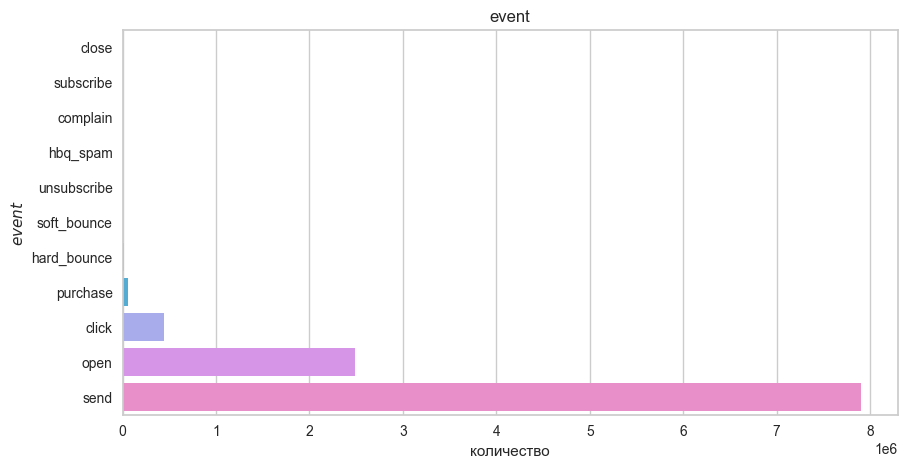

Значения столбца channel 
              Количество      Доля
channel                          
email           4825108  0.442135
mobile_push     6088089  0.557865 

Статистический анализ столбца channel 
          Количество      Доля
count  2.000000e+00  2.000000
mean   5.456598e+06  0.500000
std    8.930624e+05  0.081833
min    4.825108e+06  0.442135
25%    5.140853e+06  0.471068
50%    5.456598e+06  0.500000
75%    5.772344e+06  0.528932
max    6.088089e+06  0.557865


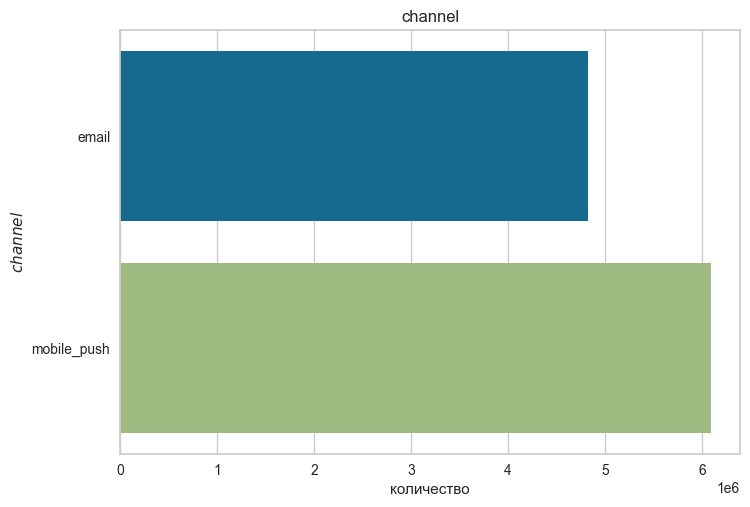

In [29]:
columns = ['event', 'channel']
messages_temp = messages[columns]
eda_quality(messages_temp)

В таблице messages мы видим множество событий. Самое распространенное - send, a purchase встречается в 141 раз меньше
<br>в столбце channel у нас более чем в 3 раза превышает рассылка по email, чем push уведомления
<br> Немного чаще рассылки проводятся с помощью push уведомлений

В таблице purchases исследуем количественные переменные в столбцах price, quantity

Статистический анализ столбца: quantity
count    129188.00
mean          1.01
std           0.22
min           1.00
25%           1.00
50%           1.00
75%           1.00
max          30.00
Name: quantity, dtype: float64


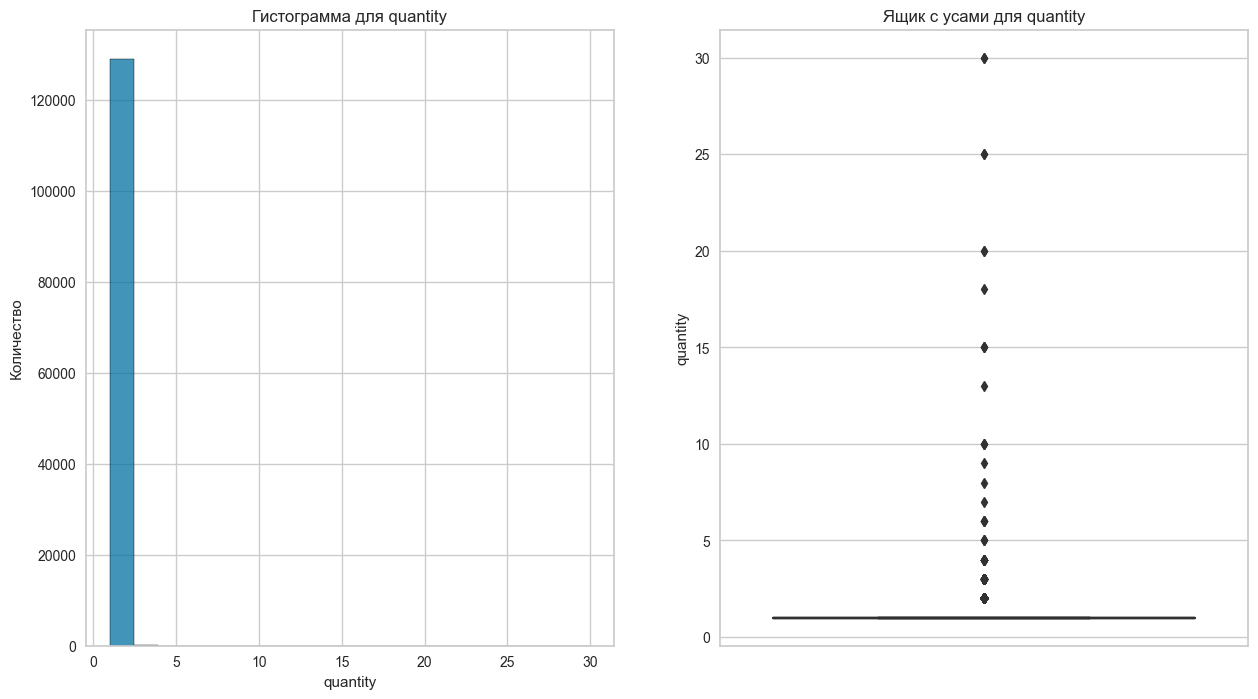

Статистический анализ столбца: price
count    129188.00
mean       1264.53
std        1375.02
min           1.00
25%         399.00
50%         999.00
75%        1750.00
max       85499.00
Name: price, dtype: float64


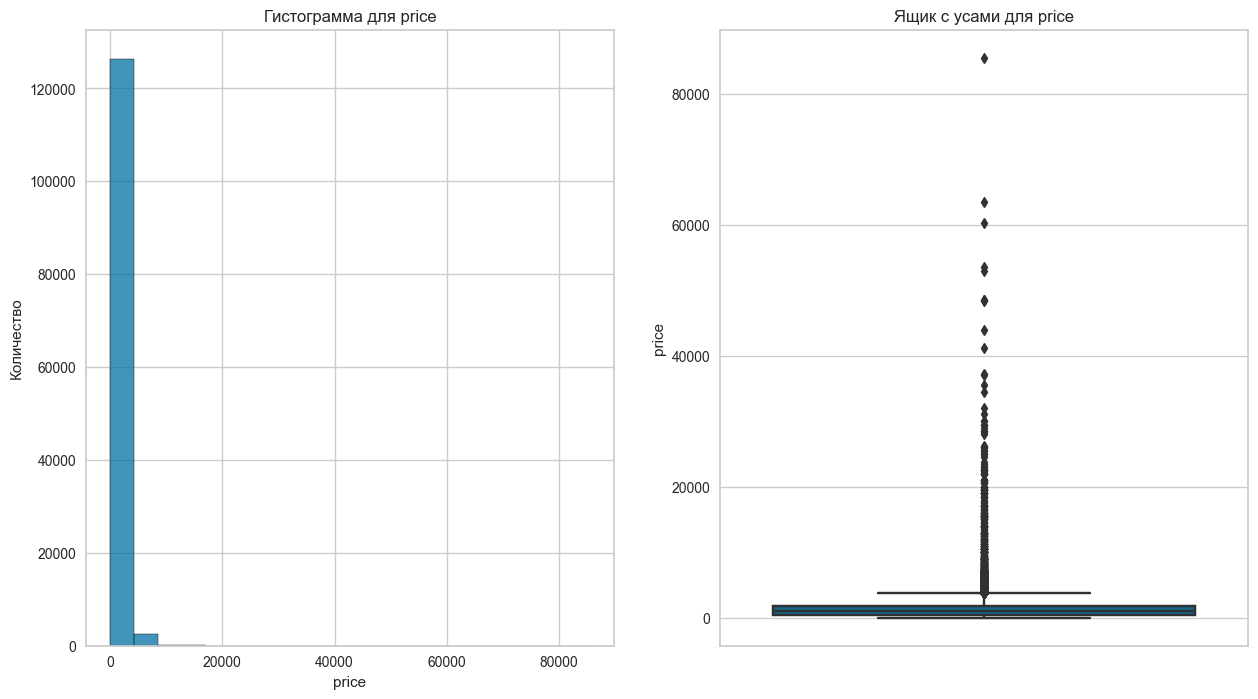

In [30]:
eda_quantity(purchases.drop('client_id', axis=1), 20)

<b>Вывод</b>
<br>В таблице messages мы видим множество событий. Самое распространенное - send, a purchase встречается в 141 раз меньше
<br>в столбце channel у нас более чем в 3 раза превышает рассылка по email, чем push уведомления
<br> Немного чаще рассылки проводятся с помощью push уведомлений
<br> В таблице purchases в столбцах purchases и price мы видим аномалии, которые вполне могут быть, если клиент брал оптом те или иные товары, оставим все как есть без измнений

## Шаг 4. Добавление новых признаков

In [31]:
message_events = pd.pivot_table(data=messages, index='client_id', columns='event', aggfunc='size',
                              fill_value=0).reset_index()

message_events.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


In [32]:
message_events.shape

(41982, 12)

In [33]:
message_channels = pd.pivot_table(data=messages, index='client_id',
                                  columns = 'channel', aggfunc='size', fill_value=0).reset_index()
message_channels.head()

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91


In [34]:
message_channels.shape

(41982, 3)

Теперь рассмотрим таблицу purchases

In [35]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [36]:
purchases.shape

(129188, 6)

добавим следующие дополнительные признаки: total_price, total_quantity, cat_1, cat_2, cat_3, cat_4 и cat_5

In [37]:
purchases['total_price'] = purchases.groupby(['client_id','message_id'])["price"].transform(lambda x: x.sum())
purchases['total_quantity'] = purchases.groupby('message_id')["quantity"].transform(lambda x: x.sum())
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,total_price,total_quantity
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4498.0,2
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4498.0,2
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3


In [38]:
purchases['category_ids'] = purchases['category_ids'].str.replace(r"[\[\]'\s]", "", regex=True).str.split(',')
max_categories = purchases['category_ids'].apply(len).max()
category_columns = [f'cat_{i+1}' for i in range(max_categories)]
purchases[category_columns] = pd.DataFrame(purchases['category_ids'].tolist(), index=purchases.index)
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,total_price,total_quantity,cat_1,cat_2,cat_3,cat_4,cat_5
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4498.0,2,4,28,57,431,None
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4498.0,2,4,28,57,431,None
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3,4,28,57,431,None
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3,4,28,244,432,None
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3,4,28,49,413,None


In [39]:
purchases.isna().sum()

client_id              0
quantity               0
price                  0
category_ids           0
date                   0
message_id             0
total_price            0
total_quantity         0
cat_1                  0
cat_2               3360
cat_3               3360
cat_4               4096
cat_5             128843
dtype: int64

Теперь удалим категорию 5, тк она редко встречается в таблице

In [40]:
purchases.drop('cat_5',axis=1)

,client_id,quantity,price,category_ids,date,message_id,total_price,total_quantity,cat_1,cat_2,cat_3,cat_4
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4498.0,2,4,28,57,431
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4498.0,2,4,28,57,431
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3,4,28,57,431
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3,4,28,244,432
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,16497.0,3,4,28,49,413
...,...,...,...,...,...,...,...,...,...,...,...,...
202196,1515915626010221592,1,1499.0,"[4, 28, 260, 1194]",2024-02-16,1515915626010221592-14664-65cf1622434a9,1499.0,1,4,28,260,1194
202198,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,1499.0,1,2,18,212,726
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,99.0,2,4,27,233,462
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,1999.0,3,2,18,274,446


In [41]:
categories = purchases[['client_id', 'cat_1', 'cat_2', 'cat_3', 'cat_4']]
categories = categories.dropna()
categories[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = categories[['cat_1', 'cat_2', 'cat_3', 'cat_4']].astype('int')
categories.shape

(125092, 5)

In [42]:
purchases_new = purchases[['client_id', 'total_quantity', 'total_price']]

purchases_new.shape

(129188, 3)

<b>Вывод</b>
<br>Создали две сводные таблицы из messages, в которых посчитаны event и способ получения сообщения
<br>В таблице purchases создали 4 новых столбца с категориями покупок (пятый, редко встречающийся, удалили), а также столбцы total_quantity и total_price, отделили для удобства таблицу с категориями и таблицу с суммой
<br> Перейдем к этапу объединения таблиц

## Шаг 5. Объединение таблиц

In [43]:
target = target.reset_index(drop=True)
message_channels = message_channels.reset_index(drop=True)
categories = categories.reset_index(drop=True)
purchases_new = purchases_new.reset_index(drop=True)

In [44]:
full = pd.merge(target, message_channels, how='left')
full = full.drop_duplicates(subset='client_id', keep='first')
full = pd.merge(full, purchases_new, on='client_id', how='left')
full = full.drop_duplicates(subset='client_id', keep='first')
full = pd.merge(full, categories, on='client_id', how='left')
full = full.drop_duplicates(subset='client_id', keep='first')
full = pd.merge(full, message_events, on='client_id', how='left')
full = full.drop_duplicates(subset='client_id', keep='first')

full.shape

(49849, 21)

In [45]:
full.isna().sum()

client_id            0
target               0
email             7867
mobile_push       7867
total_quantity       0
total_price          0
cat_1              107
cat_2              107
cat_3              107
cat_4              107
click             7867
close             7867
complain          7867
hard_bounce       7867
hbq_spam          7867
open              7867
purchase          7867
send              7867
soft_bounce       7867
subscribe         7867
unsubscribe       7867
dtype: int64

Мы видим пропущенные значения в категориях 1-4, заменим их нулями

In [46]:
full[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = full[['cat_1', 'cat_2', 'cat_3', 'cat_4']].fillna (0)
full[['email', 'mobile_push']] = full[['email', 'mobile_push']].fillna(0)

In [47]:
events = ['click', 'close', 'complain', 'hard_bounce', 'soft_bounce', 'hbq_spam',
          'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']
for e in events:
  full[[e]] = full[[e]].fillna(0)

In [48]:
full.isna().sum()

client_id         0
target            0
email             0
mobile_push       0
total_quantity    0
total_price       0
cat_1             0
cat_2             0
cat_3             0
cat_4             0
click             0
close             0
complain          0
hard_bounce       0
hbq_spam          0
open              0
purchase          0
send              0
soft_bounce       0
subscribe         0
unsubscribe       0
dtype: int64

In [49]:
full.shape

(49849, 21)

<b>Вывод</b>
<br> На данном этапе объединили получившиеся таблицы в один датасет, пропуски заполнили нулями

## Шаг 6. Корреляционный анализ данных

Разделим датасеты по целевому признаку

In [50]:
target_1 = full[full['target'] == 1].drop(['client_id'], axis=1)
target_0 = full[full['target'] == 0].drop(['client_id'], axis=1)

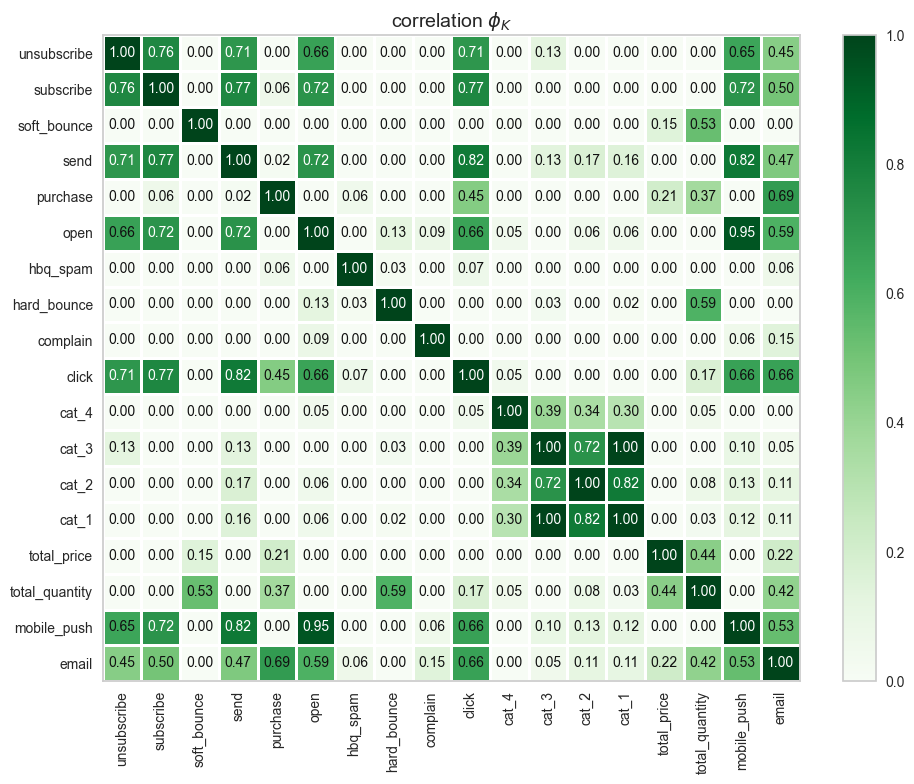

In [51]:
corr_matrix(target_1)

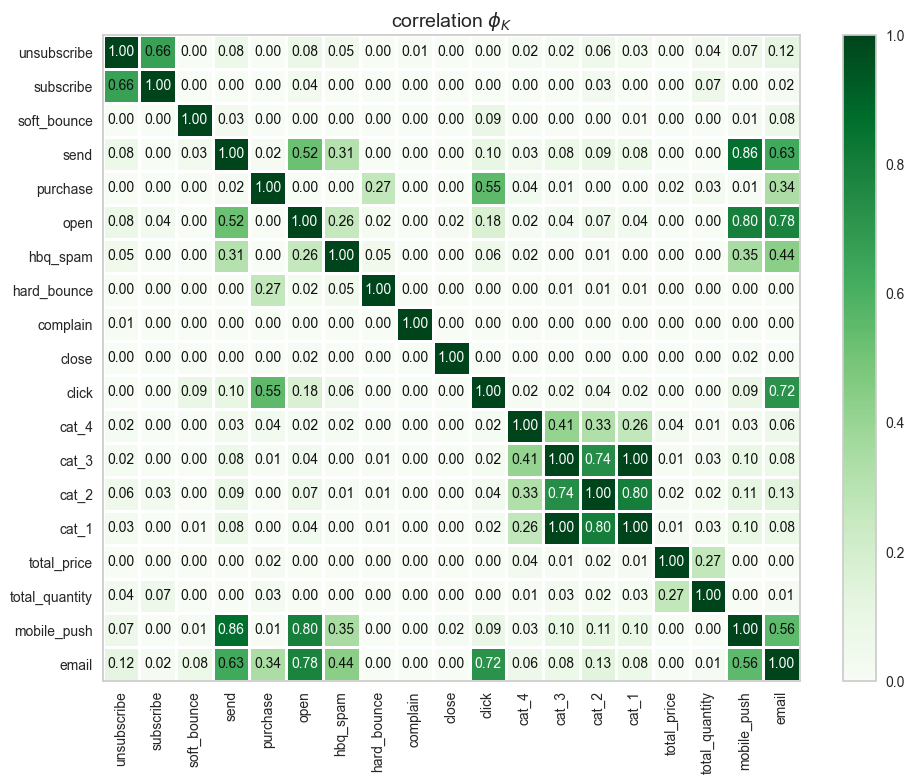

In [52]:
corr_matrix(target_0)

<b>Вывод</b>
<br>Мультиколлинеарность между признаками отсутствует, только сильная связь между некоторыми признаками, согласно шкале Чеддока

## Шаг 7. Обучение моделей

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    full.drop(['client_id', 'target'], axis=1),
    full['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = full['target']
)

In [54]:
y_train.value_counts()

target
0    36665
1      721
Name: count, dtype: int64

In [55]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Мы видим явный дисбаланс классов, будем использовать метрику roc-auc

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37386 entries, 0 to 37385
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   email           37386 non-null  float64
 1   mobile_push     37386 non-null  float64
 2   total_quantity  37386 non-null  int64  
 3   total_price     37386 non-null  float32
 4   cat_1           37386 non-null  float64
 5   cat_2           37386 non-null  float64
 6   cat_3           37386 non-null  float64
 7   cat_4           37386 non-null  float64
 8   click           37386 non-null  float64
 9   close           37386 non-null  float64
 10  complain        37386 non-null  float64
 11  hard_bounce     37386 non-null  float64
 12  hbq_spam        37386 non-null  float64
 13  open            37386 non-null  float64
 14  purchase        37386 non-null  float64
 15  send            37386 non-null  float64
 16  soft_bounce     37386 non-null  float64
 17  subscribe       37386 non-null 

In [57]:
num_col = X_train.select_dtypes(include='number').columns.tolist()

In [58]:
data_preprocessor = ColumnTransformer(
    [('num',StandardScaler(), num_col)
     #('ohe', ohe_pipe, ohe_col)
    ],
    remainder='passthrough'
)

In [59]:
param_distributions = [
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели Catboost()
         {
         'models': [CatBoostClassifier(random_seed=RANDOM_STATE, silent=True)],
         'models__depth': range(4, 10),
         'models__learning_rate': [0.01, 0.05, 0.1],
         'models__iterations': [100, 500, 1000],
         'preprocessor__num': ['passthrough']

     },
    #словарь для модели LightGBM
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [50, 100, 150],
        'models__num_leaves': [31, 50, 70],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'preprocessor__num': ['passthrough']
    },

]

In [60]:
 pipe_final = Pipeline([
     ('preprocessor', data_preprocessor),
     #('smote', smote),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
 ])

In [61]:
randomized_search=RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['email',
                                                                                'mobile_push',
                                                                                'total_quantity',
                                                                                'total_price',
                                                                                'cat_1',
                                                                                'cat_2',
                                                                                'cat_3',
                                                                                'cat_4',
                                                                                'click',
                                                                                'close',
                                                                                'complain',
                                                                                'hard_bounce',
                                                                                'hbq_spam',
                                                                                'open',
                                                                                'purchase',
                                                                                'send',
                                                                                'soft_bounce',
                                                                                'subscribe',
                                                                                'unsubscribe'])])),
                                             (...
                                         'models__iterations': [100, 500, 1000],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1],
                                         'preprocessor__num': ['passthrough']},
                                        {'models': [LGBMClassifier(class_weight='balanced',
                                                                   random_state=42)],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1],
                                         'models__n_estimators': [50, 100, 150],
                                         'models__num_leaves': [31, 50, 70],
                                         'preprocessor__num': ['passthrough']}],
                   random_state=42, scoring='roc_auc')

In [62]:
print('Метрика для лучшей модели: \n', round(randomized_search.best_score_,1))
print('\nЛучшая модель:\n\n', randomized_search.best_estimator_)
print('\nПараметры:\n\n', randomized_search.best_params_)

Метрика для лучшей модели: 
 0.7

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['email', 'mobile_push',
                                                   'total_quantity',
                                                   'total_price', 'cat_1',
                                                   'cat_2', 'cat_3', 'cat_4',
                                                   'click', 'close', 'complain',
                                                   'hard_bounce', 'hbq_spam',
                                                   'open', 'purchase', 'send',
                                                   'soft_bounce', 'subscribe',
                                                   'unsubscribe'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x000002121

In [63]:
# рассчитаем прогноз на тестовых данных
y_test_pred_proba = randomized_search.predict_proba(X_test)
print('Метрика roc_auc на тестовой выборке:', round(roc_auc_score(y_test, y_test_pred_proba[:, 1]),1))

Метрика roc_auc на тестовой выборке: 0.7


<b>Вывод</b>
<br> На данном этапе раделили датасет на тренировочную и тестовую выборки, обучили 4 модели. Лучшей оказалась CatBoostClassifier, метрика на тренировочной и тестовой выборках составляет 0,7.

## Общий вывод

<b>Этап загрузки данных</b>
<br>На данном шаге были загружены и предварительно изучены три датасета: messages, purchases, target
<br>messages содержит 12739798 строк и 7 столбцов, названия столбцов в змеином регистре, типы данных не все верны - date, created_at были приведены к типу datetime
<br>purchases содержит 202208 строк и 6 столбцов, названия столбцов соответствуют змеиному регистру, столбец date приведен к типу datetime.
<br>target - целевой датасет, содержащий 49849 строк и 2 столбца, типы данных определены верно
<br> Оптимизированы числовые типы данных для более быстрой работы

<b>Этап предобработки данных</b>
<br>Мы совершили предобработку данных, избавившись от явных дубликатов в таблицах message и purchase, неявных дубликатов обнаружено не было

<b>Исследовательский анализ данных</b>
<br><br>В таблице messages мы видим множество событий. Самое распространенное - send, a purchase встречается в 141 раз меньше
<br>в столбце channel у нас более чем в 3 раза превышает рассылка по email, чем push уведомления
<br> Немного чаще рассылки проводятся с помощью push уведомлений
<br> В таблице purchases в столбцах purchases и price мы видим аномалии, которые вполне могут быть, если клиент брал оптом те или иные товары, оставим все как есть без изменений

<b>Объединение таблиц</b>
<br> На данном этапе объединили получившиеся таблицы в один датасет, пропуски заполнили нулями

<b>Корреляционный анализ данных</b>
<br>Мультиколлинеарность между признаками отсутствует, только сильная связь между некоторыми признаками (категориями товаров), согласно шкале Чеддока. 

<b>Обучение моделей</b>
<br> Разделили датасет на тренировочную и тестовую выборки, обучили 4 модели. Лучшей оказалась CatBoostClassifier, метрика на тренировочной и тестовой выборках составляет 0,7.


Мы можем обнозначно сказать, что данные в таблице не сбалансированы. В качестве дальнейшего улучшения проекта следует поработать над дисбалансом классов в датасете. Например, использовать AdaptiveSMOTE